In [73]:
#clear df
import gc

for var in list(globals()):
    if var.startswith('df'):
        del globals()[var]

gc.collect()

1771

In [74]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

### 1. Raw data input and preprocessing

In [75]:
df_2024 = pd.read_csv('all_features_combined_exp.csv') # include poi/event/interest

print(df_2024.shape)

(38080, 26)


In [76]:
# drop event-related features
df_2024 = df_2024.drop(columns=[
    'Unnamed: 0'])

In [77]:

# total_flow = mta_flow + taxi_flow
df_2024['total_flow'] = df_2024['mta_flow'] + df_2024['taxi_flow']

# log features
for col in ['total_flow', 'mta_flow', 'taxi_flow','zone_avg_flow']:
    df_2024[f'log_{col}'] = np.log1p(df_2024[col])

# month = date 的月份
df_2024['month'] = pd.to_datetime(df_2024['date']).dt.month

In [78]:
df_2024['day'] = pd.to_datetime(df_2024['date']).dt.weekday
df_2024 = df_2024.drop(columns=['date'])

In [79]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38080 entries, 0 to 38079
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  38080 non-null  object 
 1   zone_id                   38080 non-null  int64  
 2   mta_flow                  38080 non-null  float64
 3   taxi_flow                 38080 non-null  float64
 4   trip_distance             38080 non-null  float64
 5   fare_amount               38080 non-null  float64
 6   has_congestion_surcharge  38080 non-null  float64
 7   temp                      38080 non-null  float64
 8   prcp                      38080 non-null  float64
 9   coco                      38080 non-null  float64
 10  coco_group                38080 non-null  object 
 11  total_flow                38080 non-null  float64
 12  hour                      38080 non-null  int64  
 13  weekday                   38080 non-null  int64  
 14  is_wee

In [80]:
df_2024["datetime"] = pd.to_datetime(df_2024["datetime"])

### 2. Train model with no baseline(only use historical avg data) and split test/train set

In [81]:
#seperate months
df_train_source = df_2024[df_2024['month'].isin([2, 6])]   # for creating historical baseline
df_val = df_2024[df_2024['month'] == 9]                    # validation set
df_test = df_2024[df_2024['month'] == 12] 

In [82]:
df_train_source.info()
#note 少了keyword 但就是zone_name

<class 'pandas.core.frame.DataFrame'>
Index: 18560 entries, 0 to 18559
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datetime                  18560 non-null  datetime64[ns]
 1   zone_id                   18560 non-null  int64         
 2   mta_flow                  18560 non-null  float64       
 3   taxi_flow                 18560 non-null  float64       
 4   trip_distance             18560 non-null  float64       
 5   fare_amount               18560 non-null  float64       
 6   has_congestion_surcharge  18560 non-null  float64       
 7   temp                      18560 non-null  float64       
 8   prcp                      18560 non-null  float64       
 9   coco                      18560 non-null  float64       
 10  coco_group                18560 non-null  object        
 11  total_flow                18560 non-null  float64       
 12  hour                   

In [83]:
group_cols = ['zone_id', 'hour', 'weekday']
# create historical data only in train set here
df_avg = df_train_source.groupby(group_cols).agg({
    'has_congestion_surcharge':'mean',
    'fare_amount':'mean',
    'trip_distance':'mean',
    'temp': 'mean',
    'prcp': 'mean'
}).reset_index().rename(columns={
    'has_congestion_surcharge':'has_congestion_surcharge_hist',
    'fare_amount':'fare_amount_hist',
    'trip_distance':'trip_distance_hist',
    'temp': 'temp_hist',
    'prcp': 'prcp_hist'
})

In [84]:
#merge baseline to validation and test set
df_val = df_val.merge(df_avg, on=group_cols, how='left')
df_test = df_test.merge(df_avg, on=group_cols, how='left')
df_train_source = df_train_source.merge(df_avg, on=group_cols, how='left')

In [85]:
df_train_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18560 entries, 0 to 18559
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   datetime                       18560 non-null  datetime64[ns]
 1   zone_id                        18560 non-null  int64         
 2   mta_flow                       18560 non-null  float64       
 3   taxi_flow                      18560 non-null  float64       
 4   trip_distance                  18560 non-null  float64       
 5   fare_amount                    18560 non-null  float64       
 6   has_congestion_surcharge       18560 non-null  float64       
 7   temp                           18560 non-null  float64       
 8   prcp                           18560 non-null  float64       
 9   coco                           18560 non-null  float64       
 10  coco_group                     18560 non-null  object        
 11  total_flow     

In [86]:
#create 偏差欄位
for df_target in [df_train_source,df_val, df_test]:
    df_target['temp_dev'] = df_target['temp'] - df_target['temp_hist']
    df_target['prcp_dev'] = df_target['prcp'] - df_target['prcp_hist']

In [87]:
def onehot_align(df, base_columns):
    df_encoded = pd.get_dummies(df, columns=['zone_id', 'hour', 'weekday', 'month', 'coco_group', 'category_top'], prefix_sep='_')
    missing_cols = [col for col in base_columns if col not in df_encoded.columns]
    for col in missing_cols:
        df_encoded[col] = 0
    df_encoded = df_encoded[base_columns]  # align column order
    return df_encoded

In [88]:
# 建 base_features_r
df_train_encoded = pd.get_dummies(df_train_source, columns=['zone_id', 'hour', 'weekday', 'month', 'coco_group', 'category_top'], prefix_sep='_')
features_r = [col for col in df_train_encoded.columns if col not in ['datetime', 'date', 'log_total_flow'] and df_train_encoded[col].dtype != 'object']


In [89]:
#test
leak_cols = [
    'total_flow', 'log_total_flow',
    'zone_avg_flow', 'log_zone_avg_flow',
    'mta_flow', 'log_mta_flow',
    'taxi_flow', 'log_taxi_flow'
]

features_r = [
    col for col in df_train_encoded.columns
    if col not in leak_cols + ['datetime', 'date', 'zone_name', 'keyword']
    and df_train_encoded[col].dtype in [np.int64, np.float64, np.bool_]
]

In [90]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18560 entries, 0 to 18559
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   datetime                       18560 non-null  datetime64[ns]
 1   mta_flow                       18560 non-null  float64       
 2   taxi_flow                      18560 non-null  float64       
 3   trip_distance                  18560 non-null  float64       
 4   fare_amount                    18560 non-null  float64       
 5   has_congestion_surcharge       18560 non-null  float64       
 6   temp                           18560 non-null  float64       
 7   prcp                           18560 non-null  float64       
 8   coco                           18560 non-null  float64       
 9   total_flow                     18560 non-null  float64       
 10  is_weekend                     18560 non-null  int64         
 11  lat            

In [91]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   datetime                       9600 non-null   datetime64[ns]
 1   zone_id                        9600 non-null   int64         
 2   mta_flow                       9600 non-null   float64       
 3   taxi_flow                      9600 non-null   float64       
 4   trip_distance                  9600 non-null   float64       
 5   fare_amount                    9600 non-null   float64       
 6   has_congestion_surcharge       9600 non-null   float64       
 7   temp                           9600 non-null   float64       
 8   prcp                           9600 non-null   float64       
 9   coco                           9600 non-null   float64       
 10  coco_group                     9600 non-null   object        
 11  total_flow       

In [92]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9920 entries, 0 to 9919
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   datetime                       9920 non-null   datetime64[ns]
 1   zone_id                        9920 non-null   int64         
 2   mta_flow                       9920 non-null   float64       
 3   taxi_flow                      9920 non-null   float64       
 4   trip_distance                  9920 non-null   float64       
 5   fare_amount                    9920 non-null   float64       
 6   has_congestion_surcharge       9920 non-null   float64       
 7   temp                           9920 non-null   float64       
 8   prcp                           9920 non-null   float64       
 9   coco                           9920 non-null   float64       
 10  coco_group                     9920 non-null   object        
 11  total_flow       

### 3. Result (Random Forest + Linear + xgboost)

In [93]:
X_train = df_train_encoded[features_r]
y_train = df_train_source['log_total_flow']

X_val = onehot_align(df_val, features_r)
y_val = df_val['log_total_flow']

X_test = onehot_align(df_test, features_r)
y_test = df_test['log_total_flow']

#### 3-1 Validation 

In [94]:
RF_model = RandomForestRegressor(random_state=42)
RF_model.fit(X_train, y_train)

y_val_pred = RF_model.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R2 :", r2_score(y_val, y_val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

y_pred_original = np.exp(y_val_pred)
y_val_original = np.exp(y_val)

print("MAE (original scale):", mean_absolute_error(y_val_original, y_pred_original))

Validation MAE: 0.12384138682041827
Validation R2 : 0.96700141639832
Validation RMSE: 0.18982127886345246
MAE (original scale): 445.484900870244


In [95]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

y_val_pred = LR_model.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("Validation R2 :", r2_score(y_val, y_val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

y_pred_original = np.exp(y_val_pred)
y_val_original = np.exp(y_val)

print("MAE (original scale):", mean_absolute_error(y_val_original, y_pred_original))

Validation MAE: 0.23674468643131794
Validation R2 : 0.9101059908652797
Validation RMSE: 0.3133016054454982
MAE (original scale): 882.8164832467246


In [96]:
# 建立模型（可調整參數）
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)


xgb_model.fit(X_train, y_train)


y_val_pred = xgb_model.predict(X_val)
print("XGB Validation MAE:", mean_absolute_error(y_val, y_val_pred))
print("XGB Validation R² :", r2_score(y_val, y_val_pred))
print("XGB Validation RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))


y_val_pred_original = np.exp(y_val_pred)
y_val_original = np.exp(y_val)
print("XGB Validation MAE (original scale):", mean_absolute_error(y_val_original, y_val_pred_original))

XGB Validation MAE: 0.1402156751567368
XGB Validation R² : 0.9612492108367534
XGB Validation RMSE: 0.205701529615399
XGB Validation MAE (original scale): 540.6247225761414


#### 3-2 Test

In [97]:
y_test_pred = RF_model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Test R2 :", r2_score(y_test, y_test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

y_pred_original = np.exp(y_test_pred)
y_test_original = np.exp(y_test)

print("MAE (original scale):", mean_absolute_error(y_test_original, y_pred_original))

Test MAE: 0.24381232866047925
Test R2 : 0.8994930340678977
Test RMSE: 0.3336684835847569
MAE (original scale): 917.6530627212975


In [98]:
y_test_pred = LR_model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Test R2 :", r2_score(y_test, y_test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

y_pred_original = np.exp(y_test_pred)
y_test_original = np.exp(y_test)

print("MAE (original scale):", mean_absolute_error(y_test_original, y_pred_original))

Test MAE: 0.2855087682990754
Test R2 : 0.8694877548359913
Test RMSE: 0.38022681054952845
MAE (original scale): 1051.0697373775824


In [99]:
y_test_pred = xgb_model.predict(X_test)

print("XGB Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("XGB Test R² :", r2_score(y_test, y_test_pred))
print("XGB Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

y_test_pred_original = np.exp(y_test_pred)
y_test_original = np.exp(y_test)
print("XGB Test MAE (original scale):", mean_absolute_error(y_test_original, y_test_pred_original))

XGB Test MAE: 0.2496824911843149
XGB Test R² : 0.896916901867208
XGB Test RMSE: 0.3379176198384402
XGB Test MAE (original scale): 968.2401386899332


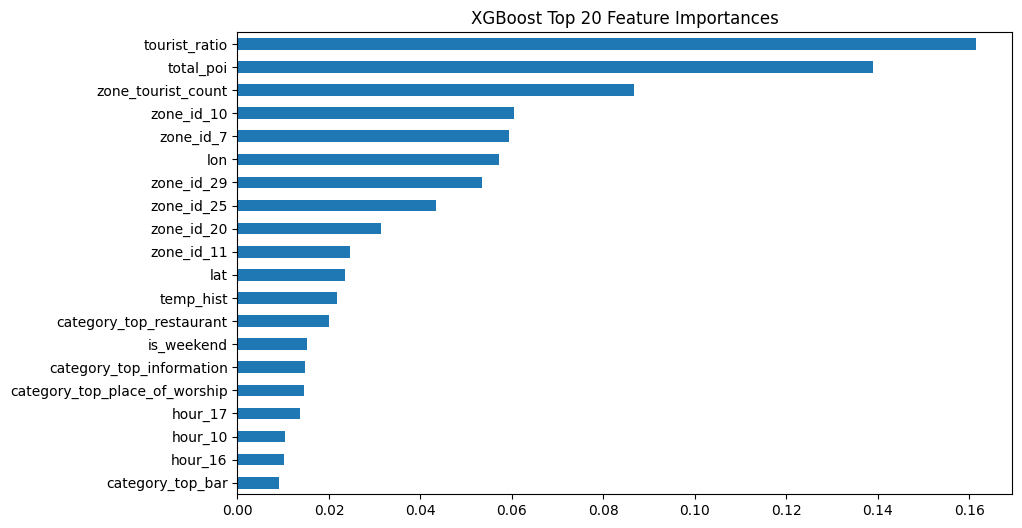

In [100]:
import matplotlib.pyplot as plt

xgb_importance = xgb_model.feature_importances_
importance_series = pd.Series(xgb_importance, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importance_series.head(20).plot(kind='barh')
plt.title("XGBoost Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### 4. Observe data

In [101]:
corrs = df_train_source.corr(numeric_only=True)['log_total_flow'].sort_values(ascending=False)
display(corrs)

log_total_flow                   1.000000
log_mta_flow                     0.995559
log_zone_avg_flow                0.861869
total_flow                       0.830882
mta_flow                         0.828908
zone_avg_flow                    0.782612
total_poi                        0.539467
taxi_flow                        0.352119
hour                             0.334887
zone_tourist_count               0.323200
temp_hist                        0.313787
interest                         0.273592
log_taxi_flow                    0.260943
fare_amount_hist                 0.165580
has_congestion_surcharge_hist    0.161495
has_congestion_surcharge         0.157763
fare_amount                      0.154432
temp                             0.093968
lon                              0.061015
lat                              0.054677
prcp_hist                        0.052752
trip_distance_hist               0.044472
temp_dev                         0.028724
month                            0

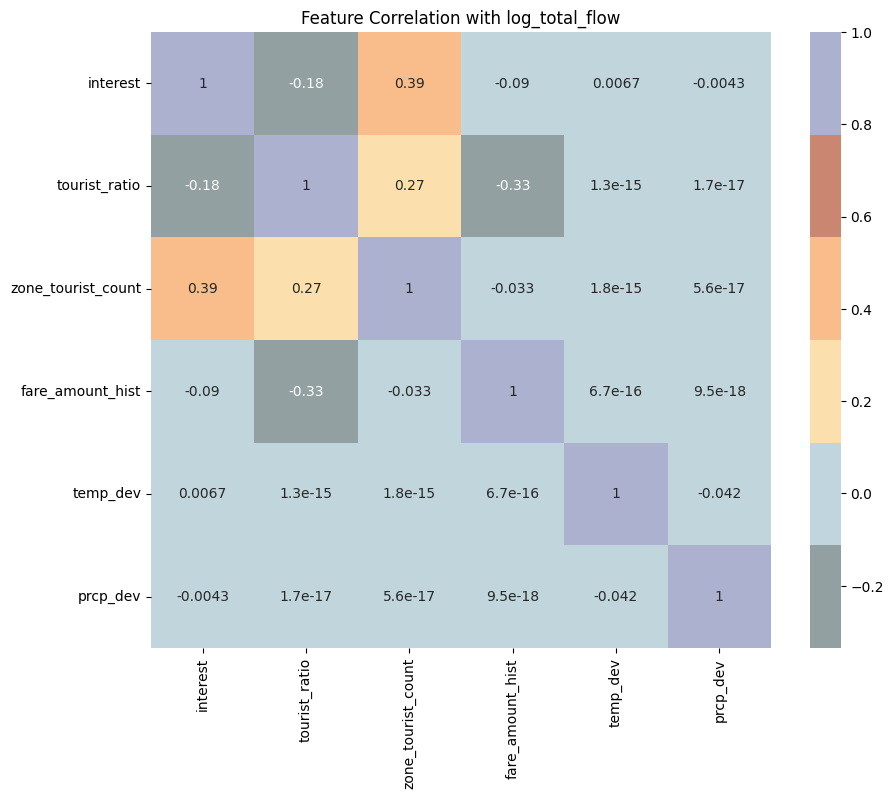

In [102]:
plt.figure(figsize=(10, 8))
custom_cmap = sns.color_palette(["#92a0a1", "#c1d6dc", "#fbe0ae", "#f8bd8b", "#ca8671","#abb1cf"], as_cmap=True)
sns.heatmap(df_train_source[[
    'interest', 'tourist_ratio', 'zone_tourist_count',
    'fare_amount_hist',
    'temp_dev', 'prcp_dev'
]].corr(), annot=True, cmap=custom_cmap)
plt.title("Feature Correlation with log_total_flow")
plt.show()


### 5. Adjust and Improved model

In [103]:
#tuning_v2
param_dist_2 = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.1, 1.0]
}

In [104]:
# #針對xgboost tuning
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# 用 MAE 當作評估指標
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_2,
    n_iter=20,            # 試 20 組（可增加）
    scoring=scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          in...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200],
                                        'reg_alpha': [0.0, 0.1],
                                        'reg_lambda': [0.1, 1.0],
                                        'subsample': [0.8, 1.0]},
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [105]:
print("Best parameters:", search.best_params_)
print("Best MAE (neg):", -search.best_score_)

Best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best MAE (neg): 0.11637903837491219


In [106]:
best_model = search.best_estimator_

y_test_pred = best_model.predict(X_test)
print("XGB Tuned Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("XGB Tuned Test R² :", r2_score(y_test, y_test_pred))
print("XGB Tuned Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

# 原始 scale
y_test_pred_original = np.exp(y_test_pred)
y_test_original = np.exp(y_test)
print("XGB Tuned Test MAE (original scale):", mean_absolute_error(y_test_original, y_test_pred_original))

XGB Tuned Test MAE: 0.24957334381097826
XGB Tuned Test R² : 0.8965948155809956
XGB Tuned Test RMSE: 0.338445125066475
XGB Tuned Test MAE (original scale): 955.8459098454445


In [107]:
y_train_pred = best_model.predict(X_train)
print("Train R2:", r2_score(y_train, y_train_pred))
print("Train MAE:", mean_absolute_error(np.exp(y_train), np.exp(y_train_pred)))


Train R2: 0.9923149336710497
Train MAE: 212.56015366603586


In [108]:
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-val R² (train only):", scores.mean(), "+/-", scores.std())

Cross-val R² (train only): 0.9695442429931542 +/- 0.008408189571420742


### 6. model input and pkl

In [109]:
import joblib
model_imp = XGBRegressor()
model_imp.fit(X_train,y_train)

joblib.dump(model_imp, "xgboost_model_0708_exp.pkl")

['xgboost_model_0708_exp.pkl']

In [110]:
loaded_model = joblib.load("xgboost_model_0708_exp.pkl")
model_features = loaded_model.feature_names_in_
print(model_features)

['trip_distance' 'fare_amount' 'has_congestion_surcharge' 'temp' 'prcp'
 'coco' 'is_weekend' 'lat' 'lon' 'interest' 'total_poi'
 'zone_tourist_count' 'tourist_ratio' 'has_congestion_surcharge_hist'
 'fare_amount_hist' 'trip_distance_hist' 'temp_hist' 'prcp_hist'
 'temp_dev' 'prcp_dev' 'zone_id_0' 'zone_id_1' 'zone_id_2' 'zone_id_4'
 'zone_id_5' 'zone_id_6' 'zone_id_7' 'zone_id_8' 'zone_id_9' 'zone_id_10'
 'zone_id_11' 'zone_id_12' 'zone_id_13' 'zone_id_14' 'zone_id_15'
 'zone_id_16' 'zone_id_17' 'zone_id_18' 'zone_id_19' 'zone_id_20'
 'zone_id_21' 'zone_id_22' 'zone_id_23' 'zone_id_24' 'zone_id_25'
 'zone_id_26' 'zone_id_27' 'zone_id_28' 'zone_id_29' 'zone_id_30'
 'zone_id_31' 'hour_9' 'hour_10' 'hour_11' 'hour_12' 'hour_13' 'hour_14'
 'hour_15' 'hour_16' 'hour_17' 'hour_18' 'weekday_0' 'weekday_1'
 'weekday_2' 'weekday_3' 'weekday_4' 'weekday_5' 'weekday_6' 'month_2'
 'month_6' 'coco_group_Clear/Fair' 'coco_group_Cloudy/Overcast'
 'coco_group_Fog/Low-Vis' 'coco_group_Heavy Rain'
 'coc

In [111]:
# -----------------------------
# fixed cols 
# -----------------------------
cat_cols = ['coco_group', 'category_top']           
num_cols = [
            'lat','lon',
            'zone_tourist_count', 'tourist_ratio',
            'zone_avg_flow', 'log_zone_avg_flow']

In [112]:
import pandas as pd
import json, pathlib


df_input = df_train_source.copy()

# (a) categorical cols
cat_part = (
    df_input.groupby('zone_id')[cat_cols]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else None)
)

# (b) continuous
num_part = df_input.groupby('zone_id')[num_cols].mean()

# (c) cat and output
zone_defaults = cat_part.join(num_part).reset_index()

# list[dict] and save
pathlib.Path('zone_defaults.json').write_text(
    json.dumps(zone_defaults.to_dict(orient='records'),
            ensure_ascii=False, indent=2)
)
print('output done, includes ',
      len(zone_defaults), 'zone')


output done, includes  31 zone


In [113]:
hist_cols = ['temp_hist', 'prcp_hist',
             'fare_amount_hist', 'trip_distance_hist',
             'has_congestion_surcharge_hist']

global_defaults = df_input[hist_cols].mean().to_dict()

pathlib.Path('global_defaults.json').write_text(
    json.dumps(global_defaults, ensure_ascii=False, indent=2)
)
print('output global_defaults.json')

output global_defaults.json


In [114]:
import json, pathlib

pathlib.Path('features_r.json').write_text(
    json.dumps(features_r, ensure_ascii=False, indent=2)
)
print('features_r.json saved –', len(features_r), 'columns')

features_r.json saved – 87 columns


In [115]:
import joblib, pathlib, json


model       = xgb_model                     # xgboost 實例
features_r  = features_r                   # list[str]，欄位順序

# 打包並存檔
joblib.dump({'model': model, 'features_r': features_r}, 'ML_XGB.pkl')
print('Saved: ML_xgb.pkl')

Saved: ML_xgb.pkl


### 7. Historical statistic for visualise the peak time in each zone each weekday and per hour

In [116]:
# group by zone, hour, weekday 來取得歷史平均 log_total_flow
zone_flow_pattern = df_train_source.groupby(['zone_id', 'weekday', 'hour'])['log_total_flow'].mean().reset_index()
zone_flow_pattern['avg_flow'] = np.exp(zone_flow_pattern['log_total_flow'])

In [122]:
zone_flow_pattern.head(20)

,zone_id,weekday,hour,log_total_flow,avg_flow
0,0,0,9,7.815738,2479.316303
1,0,0,10,7.537888,1877.860015
2,0,0,11,7.670706,2144.594672
3,0,0,12,7.864598,2603.463687
4,0,0,13,7.978158,2916.552754
5,0,0,14,8.237205,3778.962702
6,0,0,15,8.565516,5247.549001
7,0,0,16,8.884762,7221.093832
8,0,0,17,9.179452,9695.835888
9,0,0,18,8.737183,6230.320752


In [118]:
def get_zone_daily_pattern(zone_id, zone_flow_pattern):
    """
    傳入 zone_id 與 zone_flow_pattern DataFrame，回傳該區一週每日的擁擠與建議時段
    """

    # 過濾指定區域資料
    zone_df = zone_flow_pattern[zone_flow_pattern['zone_id'] == zone_id]

    # 定義擁擠 / 推薦時間抽取邏輯
    def get_peak_and_recommend(df):
        peak = df.loc[df['avg_flow'].idxmax()]
        rec = df.loc[df['avg_flow'].idxmin()]
        return pd.Series({
            'peak_hour': int(peak['hour']),
            'peak_flow': round(peak['avg_flow']),
            'recommend_hour': int(rec['hour']),
            'recommend_flow': round(rec['avg_flow'])
        })

    # 對每個 weekday 抽取最大/最小值
    zone_result = (
        zone_df.groupby('weekday')
        .apply(get_peak_and_recommend)
        .reset_index()
    )
    zone_result['zone_id'] = zone_id
    return zone_result[['zone_id', 'weekday', 'peak_hour', 'peak_flow', 'recommend_hour', 'recommend_flow']]


In [120]:
get_zone_daily_pattern(30, zone_flow_pattern)

C:\Users\mm921\AppData\Local\Temp\ipykernel_56076\2649340628.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_peak_and_recommend)


,zone_id,weekday,peak_hour,peak_flow,recommend_hour,recommend_flow
0,30,0,17,2535,11,661
1,30,1,17,2952,11,712
2,30,2,17,2960,11,823
3,30,3,17,3119,11,747
4,30,4,17,2709,10,681
5,30,5,18,1033,9,483
6,30,6,16,767,9,356


In [121]:
get_zone_daily_pattern(11, zone_flow_pattern)

C:\Users\mm921\AppData\Local\Temp\ipykernel_56076\2649340628.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_peak_and_recommend)


,zone_id,weekday,peak_hour,peak_flow,recommend_hour,recommend_flow
0,11,0,17,3592,10,766
1,11,1,17,4463,10,831
2,11,2,17,5015,10,895
3,11,3,17,5094,10,866
4,11,4,16,3723,9,837
5,11,5,17,2835,9,477
6,11,6,17,2598,9,455
